In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import v2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim


In [16]:
transform=v2.Compose([
    v2.ToImage(), 
    v2.Resize((28, 28)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5], std=[0.5])
])


In [17]:
train_path = '../data/monkey_data/monkey_training/'
test_path = '../data/monkey_data/monkey_testing/'
labels_path = '../data/monkey_data/monkey_labels.txt'

# Load training data
train_data = datasets.ImageFolder(root=train_path, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)

# Load testing data
test_data = datasets.ImageFolder(root=test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)

In [18]:
train_data

Dataset ImageFolder
    Number of datapoints: 1097
    Root location: ../data/monkey_data/monkey_training/
    StandardTransform
Transform: Compose(
                 ToImage()
                 Resize(size=[28, 28], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 ToDtype(scale=True)
                 Normalize(mean=[0.5], std=[0.5], inplace=False)
           )

In [19]:
train_data.classes

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [20]:
# shape of the data
train_data[0][0].shape # 3 channels, 100x100 pixels

torch.Size([3, 28, 28])

In [21]:
# Load labels from file
labels_path = '../data/monkey_data/monkey_labels.txt'
with open(labels_path, 'r') as file:
    labels = file.readlines()
labels = [label.strip() for label in labels]


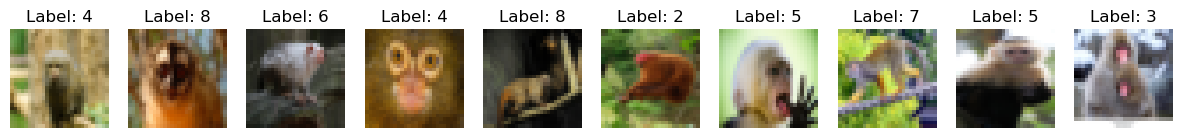

In [22]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy() # convert to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # Transpose the image to be in the correct format for matplotlib.
    plt.show()

images, labels = next(iter(train_loader))
fig, axs = plt.subplots(1, 10, figsize=(15, 15))

for i in range(10):
    axs[i].imshow(np.transpose((images[i] / 2 + 0.5).numpy(), (1, 2, 0)))
    axs[i].set_title(f'Label: {labels[i].item()}')
    axs[i].axis('off')

plt.show()

In [23]:
class MonkeyNet(nn.Module):
    def __init__(self):
        super(MonkeyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5) # 1 channel in, 10 filters out, 5x5 kernel.
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # 10 channels in, 20 filters out, 5x5 kernel.
        self.conv2_drop = nn.Dropout2d() # Dropout layer. Randomly zeroes some of the elements of the input tensor with probability p. This helps to prevent overfitting.
        self.fc1 = nn.Linear(320, 100)
        self.fc2 = nn.Linear(100, 10) # 10 output classes corresponding to digits 0-9.

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # Max pooling layer with 2x2 kernel. This reduces the size of the image by half.
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) # Dropout layer applied to the second convolutional layer.
        x = x.view(-1, 320) # Flatten the tensor.
        x = F.relu(self.fc1(x)) # Fully connected layer. ReLU activation function.
        x = F.dropout(x, training=self.training) # Dropout layer applied to the fully connected layer.
        x = self.fc2(x) # Fully connected layer. 
        return F.log_softmax(x, dim=1)

model = MonkeyNet()

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MonkeyNet(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [26]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # By resetting the gradients to zero at the start of each training iteration, you ensure that the gradient values computed are only from the current batch of data.
        output = model(data)
        loss = criterion(output, target)
        loss.backward() # Backpropagation. Computes the gradient of the loss with respect to all the model parameters.
        optimizer.step() # Optimizer. Updates the model parameters based on the gradients computed in the backward pass.
        if batch_idx % 25 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [27]:
def monkey_test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [28]:
epoch = 100
for epoch in range(1, epoch + 1):
    train(epoch)
    monkey_test()

torch.save(model.state_dict(), "monkey_species_model.pt")

Train Epoch: 1 [0/1097 (0%)]	Loss: 2.313602

Test set: Average loss: 0.0254, Accuracy: 28/272 (10%)

Train Epoch: 2 [0/1097 (0%)]	Loss: 2.301058

Test set: Average loss: 0.0254, Accuracy: 43/272 (16%)

Train Epoch: 3 [0/1097 (0%)]	Loss: 2.299611

Test set: Average loss: 0.0253, Accuracy: 41/272 (15%)

Train Epoch: 4 [0/1097 (0%)]	Loss: 2.301805

Test set: Average loss: 0.0252, Accuracy: 43/272 (16%)

Train Epoch: 5 [0/1097 (0%)]	Loss: 2.294638

Test set: Average loss: 0.0251, Accuracy: 56/272 (21%)

Train Epoch: 6 [0/1097 (0%)]	Loss: 2.306047

Test set: Average loss: 0.0250, Accuracy: 72/272 (26%)

Train Epoch: 7 [0/1097 (0%)]	Loss: 2.258965

Test set: Average loss: 0.0247, Accuracy: 72/272 (26%)

Train Epoch: 8 [0/1097 (0%)]	Loss: 2.263229

Test set: Average loss: 0.0244, Accuracy: 78/272 (29%)

Train Epoch: 9 [0/1097 (0%)]	Loss: 2.244076

Test set: Average loss: 0.0239, Accuracy: 78/272 (29%)

Train Epoch: 10 [0/1097 (0%)]	Loss: 2.215168

Test set: Average loss: 0.0232, Accuracy: 81/